In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import random
import numpy as np

In [3]:
from utils import *
from param_init import *
from exact_sol import *
from evaluation import *

set_seed()

In [4]:
specs = {
       'm':  {'mean': 1.0,  'std': 0.1, 'lower_multiplier': -2, 'upper_multiplier': 8},
       'mu': {'mean': 0.6,  'std': 0.05, 'lower_multiplier': -8, 'upper_multiplier': 2},
       'k':  {'mean': 5.0,  'std': 0.5, 'lower_multiplier': -5, 'upper_multiplier': 5},
       'y0': {'mean': -0.4, 'std': 0.1, 'lower_multiplier': -5, 'upper_multiplier': 5},
       'v0': {'mean': 3.0,  'std': 0.5, 'lower_multiplier': -5, 'upper_multiplier': 5},
    }

# Run training pipeline
params=initialize_param(500,distribute=['m','mu'],specs=specs, normalize=True)

Epoch 0, PDE loss: 0.0015021864091977477, BC loss: 7.132118753361283e-06


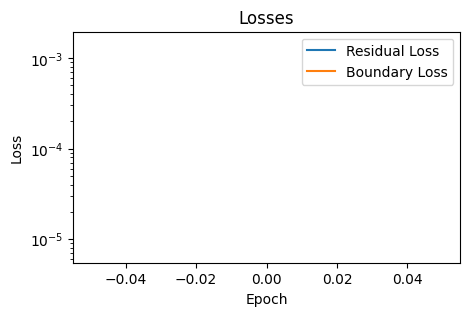

Epoch 1000, PDE loss: 0.0065885852091014385, BC loss: 0.0003145381633657962


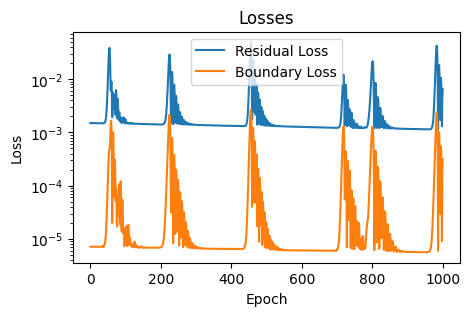

Epoch 2000, PDE loss: 0.0009104519849643111, BC loss: 4.220807568344753e-06


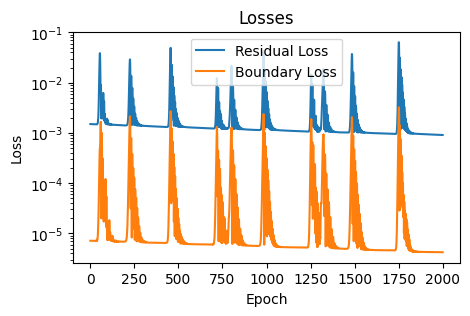

Epoch 3000, PDE loss: 0.0007521900115534663, BC loss: 3.3533538044139277e-06


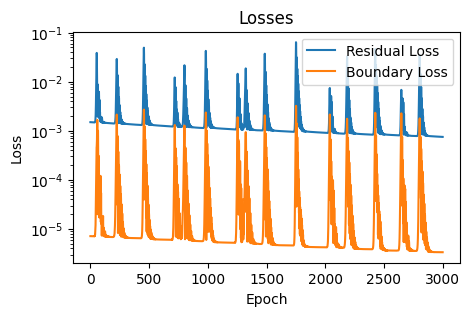

Epoch 4000, PDE loss: 0.0006854246603325009, BC loss: 4.799834641744383e-06


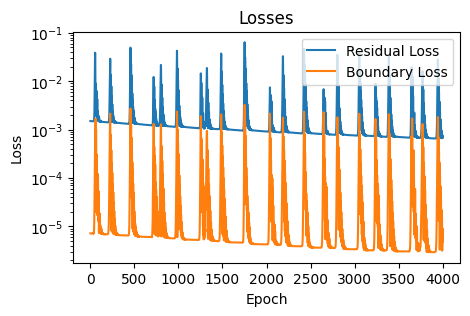

Epoch 5000, PDE loss: 0.0005784300738014281, BC loss: 2.9863583677069983e-06


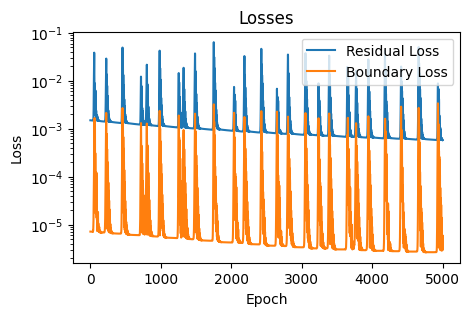

Epoch 6000, PDE loss: 0.0005252928240224719, BC loss: 2.465558281983249e-06


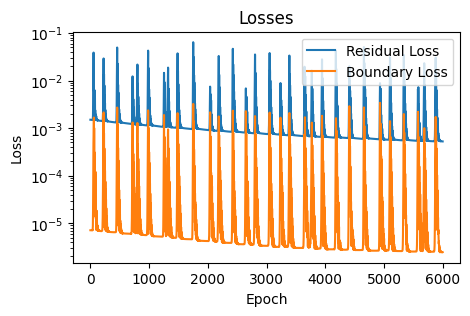

Epoch 7000, PDE loss: 0.0004823736089747399, BC loss: 2.3615148165845312e-06


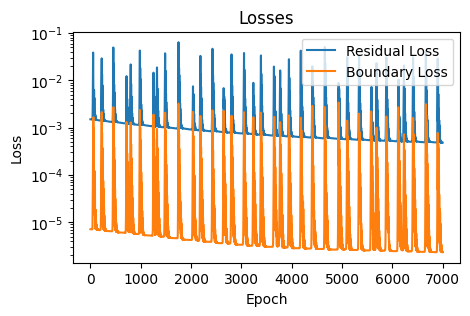

Epoch 8000, PDE loss: 0.0004498171911109239, BC loss: 2.1658236164512346e-06


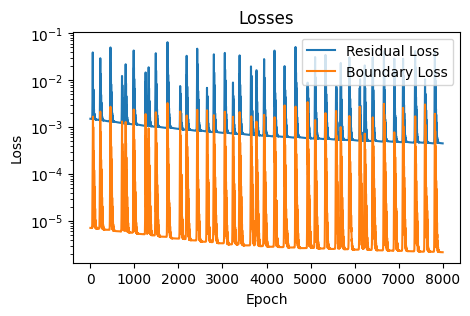

Phase 1 complete. Best loss so far: 0.00047147541772574186
Improved loss found: 0.0004713750386144966 (after 1 extra epochs)


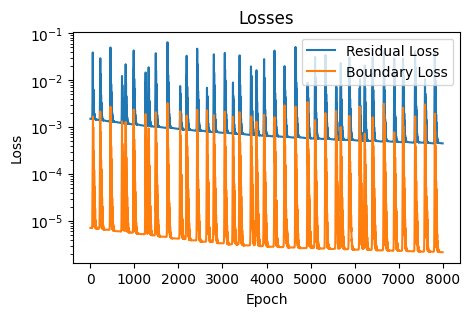

In [305]:
mass_mu_model = PINN_vanilla_oscillator(hidden_size=20, hidden_layers=3)
optimizer = optim.Adam(mass_mu_model.parameters(), lr=0.001)
trainer = Trainer(mass_mu_model, optimizer,epochs=8001)
trainer.train(params)

In [306]:
m_mean, m_std = specs['m']['mean'], specs['m']['std']
mu_mean, mu_std = specs['mu']['mean'], specs['mu']['std']
k_mean, k_std = specs['k']['mean'], specs['k']['std']
y0_mean, y0_std = specs['y0']['mean'], specs['y0']['std']
v0_mean, v0_std = specs['v0']['mean'], specs['v0']['std']

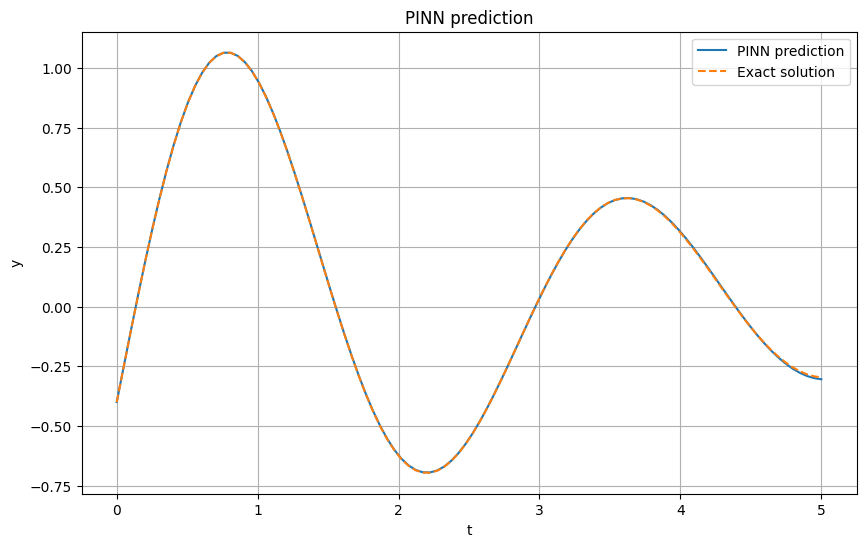

In [307]:
t_test = torch.linspace(0, 5, 100).view(-1, 1)
test_values = [m_mean, mu_mean, k_mean, y0_mean, v0_mean]

test_params = make_input_params(t_test, test_values, params['norm_info'])

y_pred= mass_mu_model(t_test, *test_params)
y_sol = damped_harmonic_oscillator(t_test.detach().numpy(), *test_values)

plt.figure(figsize=(10, 6))
plt.plot(t_test.detach().numpy(), y_pred.detach().numpy(), label='PINN prediction')
plt.plot(t_test.detach().numpy(), y_sol,label='Exact solution', linestyle='--')
plt.legend()
plt.title('PINN prediction')
plt.xlabel('t')
plt.ylabel('y')
plt.grid()
plt.show()

In [308]:
import itertools

m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 6)
mu_values = np.linspace(mu_mean - 8 * mu_std, mu_mean + 2 * mu_std, 6) 

t_test = torch.linspace(0, 5, 100).view(-1, 1)
errors = []
combos = list(itertools.product(m_values, mu_values))

for combo in combos:
    m_val_combo, mu_val_combo = combo

    test_values = [m_val_combo, mu_val_combo, k_mean, y0_mean, v0_mean]
    test_params = make_input_params(t_test, test_values, params['norm_info'])
    
    # Get the PINN prediction
    y_pred = mass_mu_model(t_test, *test_params)
    # Compute the exact solution using the provided function (convert t_test to numpy)
    y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), 
                                         *test_values)
    # Compute the mean squared error for this combination
    mse = np.mean((y_pred.detach().numpy() - y_exact)**2)
    errors.append(mse)
    # print(f"Combination (m, mu)=({m_val_combo:.2f}, {mu_val_combo:.2f}) -> MSE = {mse:.6f}")

combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all combinations: {combined_mse:.6f}")


Combined Mean Squared Error over all combinations: 0.000165


Combined Mean Squared Error over all combinations: 0.009084

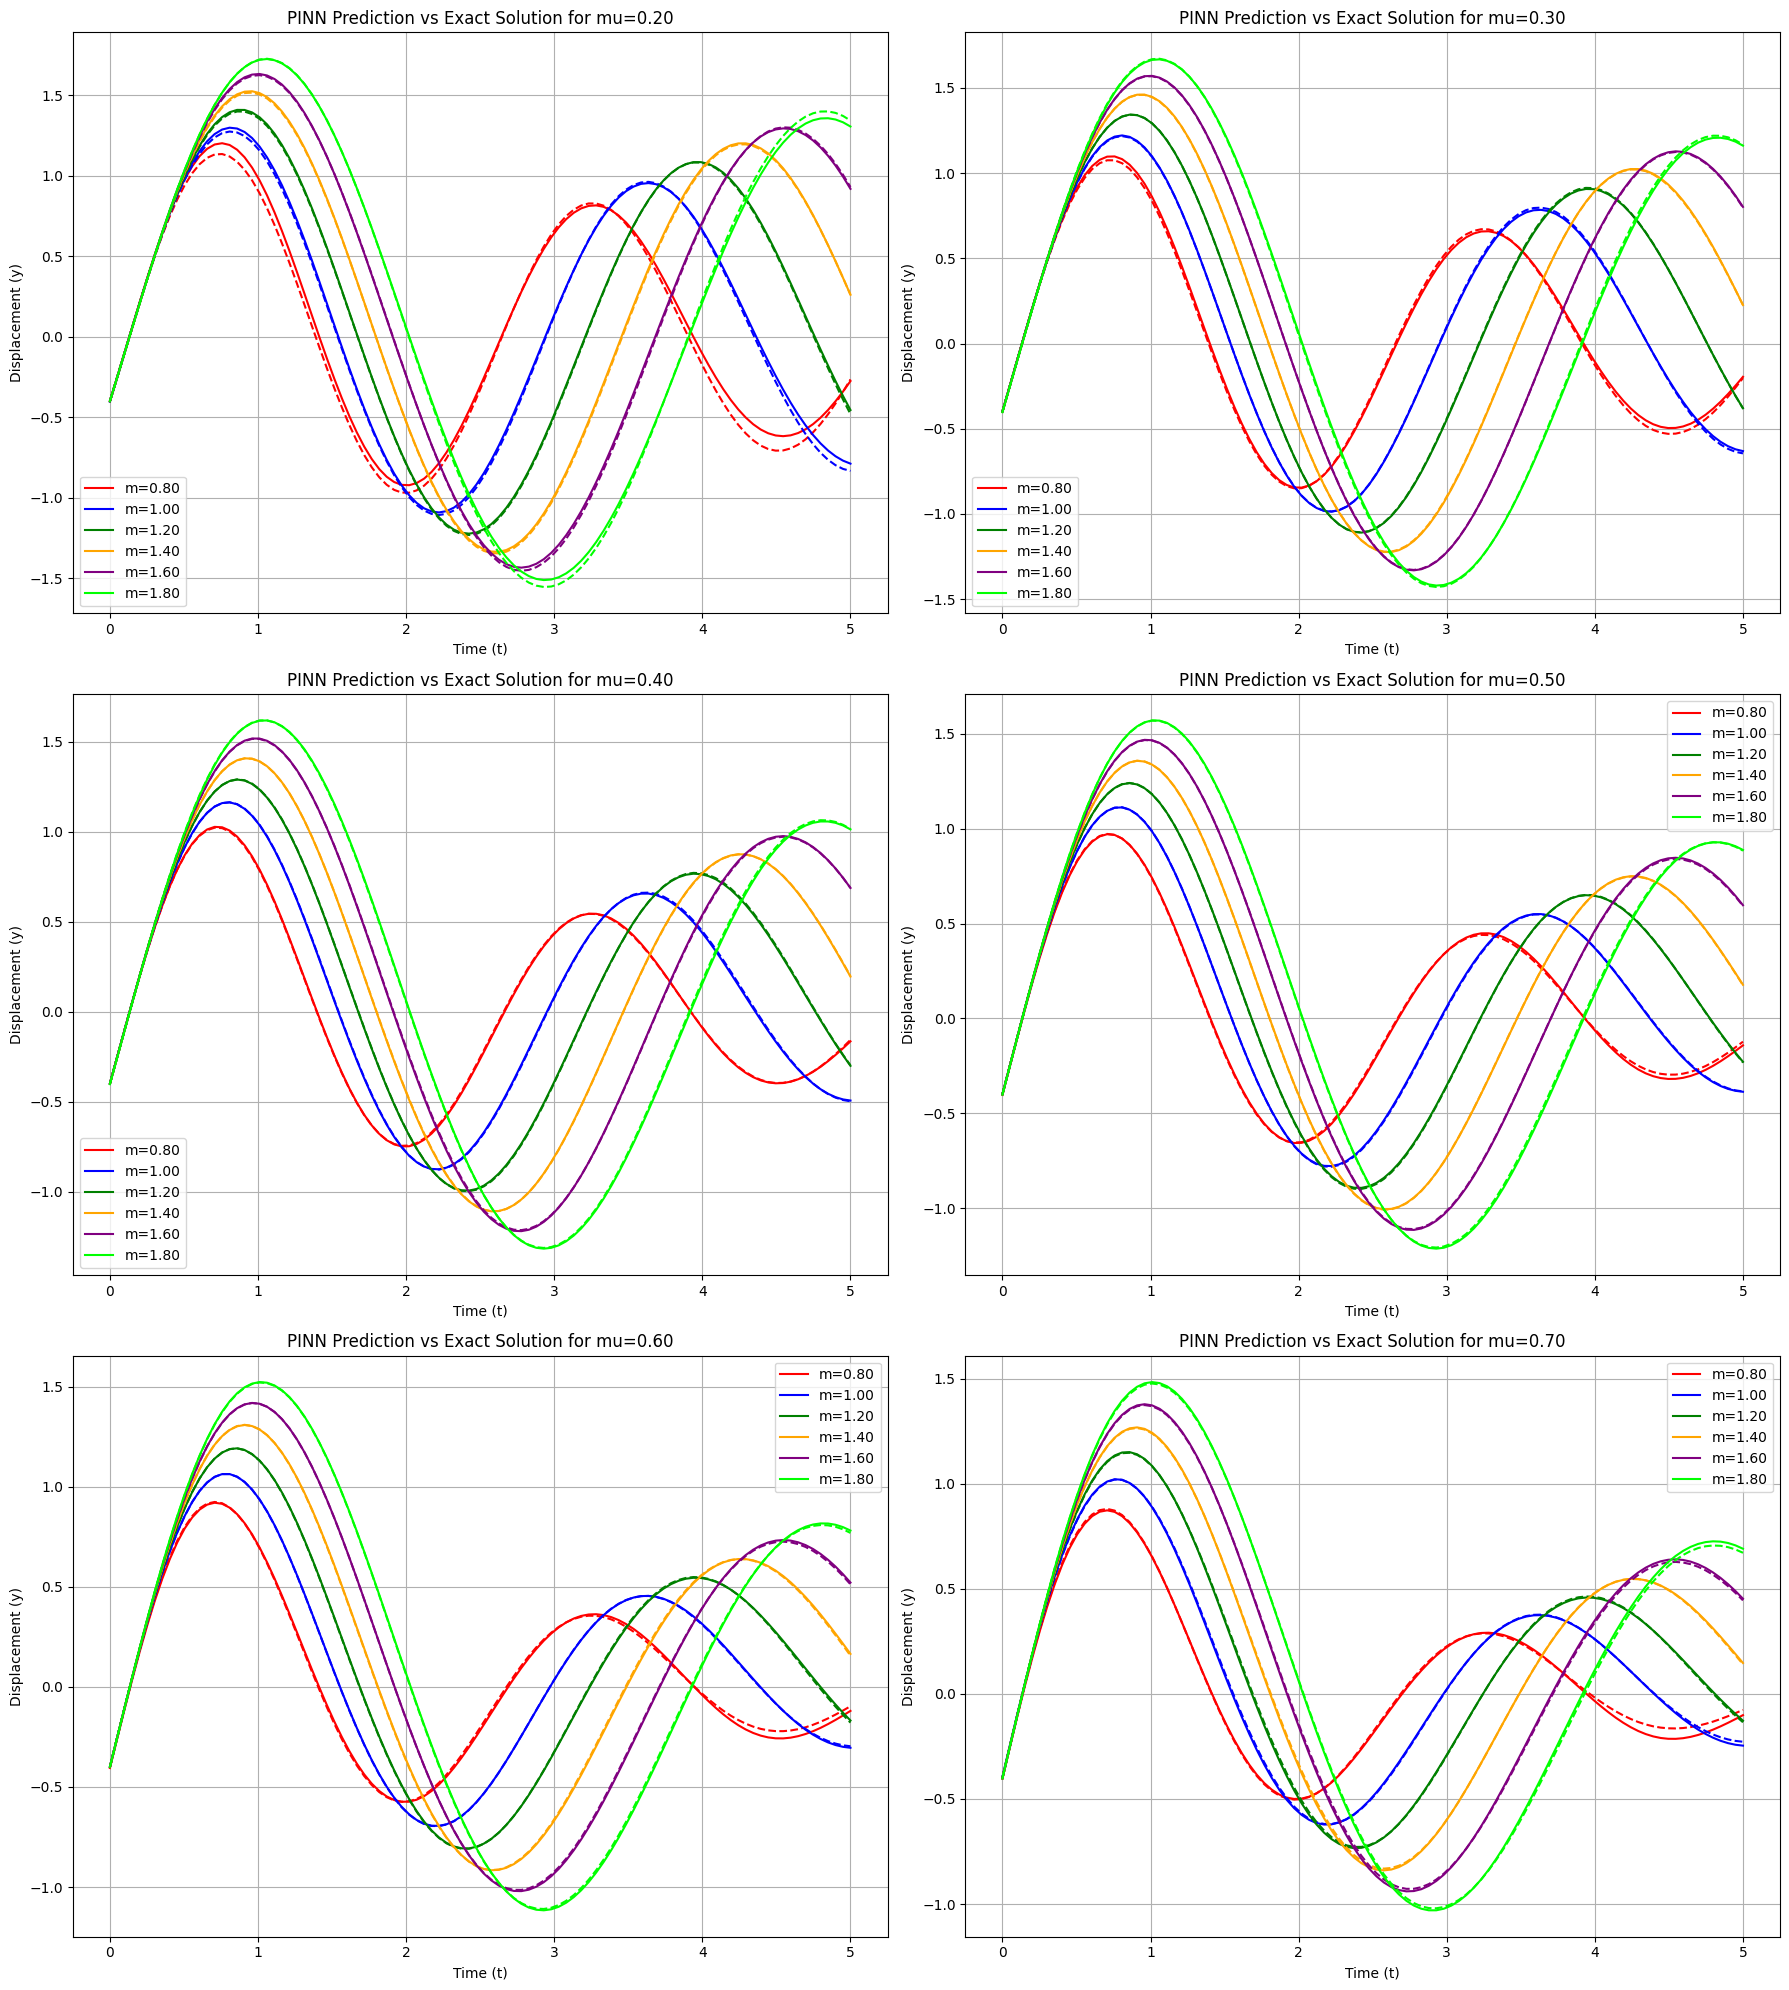

In [309]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'lime', 'brown', 'pink', 'gray', 'cyan']
fig, axes = plt.subplots(3, 2, figsize=(18, 20))
axes = axes.flatten()

for ax, mu in zip(axes,mu_values):

    for idx, m in enumerate(m_values):
        test_values = [m, mu, k_mean, y0_mean, v0_mean]
        test_params = make_input_params(t_test, test_values, params['norm_info'])
        
        # Get the PINN prediction
        y_pred = mass_mu_model(t_test, *test_params)
        # Compute the exact solution using the provided function (convert t_test to numpy)
        y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), 
                                             *test_values)
        
        ax.plot(t_test.detach().numpy(), y_pred.detach().numpy(), color=colors[idx], label=f'm={m:.2f}')
        ax.plot(t_test.detach().numpy(), y_exact, color=colors[idx], linestyle='--')

    ax.set_title(f'PINN Prediction vs Exact Solution for mu={mu:.2f}')
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Displacement (y)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

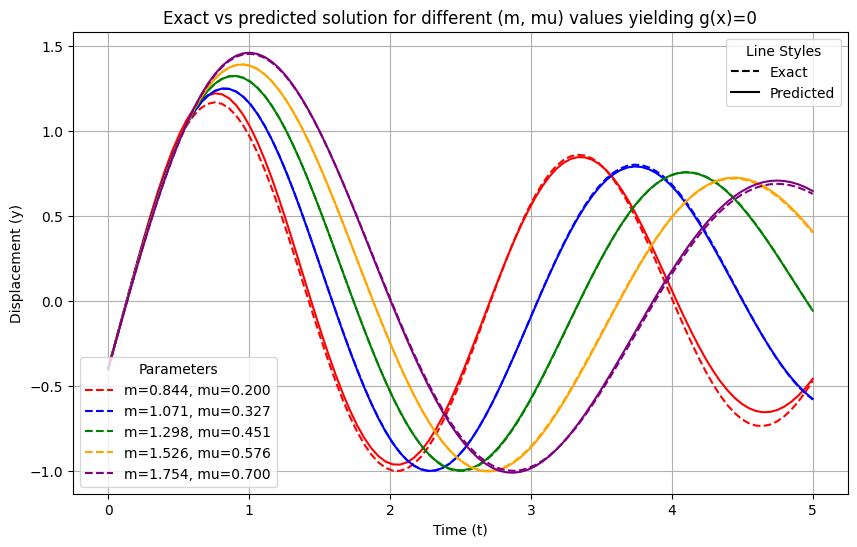


Combined Mean Squared Error over all 910 combinations: 0.000113


In [310]:
# g(x) = 0.0 for exact solution

from scipy.optimize import root_scalar

# Function to find mu for a given m where the exact solution is -1.0
def find_mu_g_equal_0(t,m,k, y0, v0, mu_bracket=(0.0, 2.0)):
    # Define the objective: we want the minimum of the solution to be -1
    def objective(mu):
        y_exact = damped_harmonic_oscillator(t, m=m, mu=mu, k=k, y0=y0, v0=v0)
        return np.min(y_exact) + 1.0  # When np.min(y_exact) == -1, this equals zero

    # Before starting, check that the bracket endpoints produce opposite signs
    a, b = mu_bracket
    if objective(a) * objective(b) > 0:
        raise ValueError("No sign change found in the objective function. Adjust mu_bracket values.")
    
    # Use the Brent's method (root_scalar with method='brentq') to find the root
    result = root_scalar(objective, bracket=mu_bracket, method='brentq')
    if result.converged:
        return result.root
    else:
        raise RuntimeError("Root finding did not converge.")

# Find mu values for each m
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 1000)
mu_values = []
t_test = np.linspace(0, 5, 100)

for m in m_values:
    mu_values.append(find_mu_g_equal_0(t_test, m, k_mean, y0_mean, v0_mean))

# Filter mu_values (and corresponding m_values) in one go:
filtered = [(m, mu) for m, mu in zip(m_values, mu_values)
            if mu_mean - 8 * mu_std <= mu <= mu_mean + 2 * mu_std]

#Plott and compare the exact and predicted solutions for the filtered (m, mu) pairs
plt.figure(figsize=(10, 6))
idx=0
# Select five evenly distributed indices from the filtered list
selected_indices = np.linspace(0, len(filtered) - 1, 5, dtype=int)

for i in selected_indices:
    m, mu = filtered[i]
    color = colors[idx]  # Cycle through colors if idx exceeds length

    y_exact = damped_harmonic_oscillator(t_test, m=m, mu=mu, k=k_mean, y0=y0_mean, v0=v0_mean)

    pred_params = make_input_params(t_test, [m, mu, k_mean, y0_mean, v0_mean], params['norm_info'])
    y_pred = mass_mu_model(torch.from_numpy(t_test).float().view(-1, 1), *pred_params)

    plt.plot(t_test, y_exact, label=f'm={m:.3f}, mu={mu:.3f}', linestyle='--', color=color)
    plt.plot(t_test, y_pred.detach().numpy(), color=color)

    idx += 1
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.title('Exact vs predicted solution for different (m, mu) values yielding g(x)=0')
plt.legend(loc='lower left')
plt.grid(True)

# Create dummy lines for the style legend
from matplotlib.lines import Line2D
line_exact = Line2D([0], [0], color='black', lw=1.5, linestyle='--')
line_pred = Line2D([0], [0], color='black', lw=1.5, linestyle='-')
# First legend for the (m, mu) labels
legend1 = plt.legend(loc='lower left', title='Parameters')
plt.gca().add_artist(legend1)
# Second legend for the line styles (exact vs predicted)
plt.legend([line_exact, line_pred], ['Exact', 'Predicted'], loc='upper right', title='Line Styles')

plt.show()

errors = []
for m,mu in filtered:
    y_exact = damped_harmonic_oscillator(t_test, m=m, mu=mu, k=k_mean, y0=y0_mean, v0=v0_mean)

    pred_params = make_input_params(t_test, [m, mu, k_mean, y0_mean, v0_mean], params['norm_info'])
    y_pred = mass_mu_model(torch.from_numpy(t_test).float().view(-1, 1), *pred_params)

    mse = np.mean((y_pred.detach().numpy().flatten() - y_exact) ** 2)
    errors.append(mse)    
combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all {len(errors)} combinations: {combined_mse:.6f}")

In [311]:
# Finding the MPP



### FORM

In [312]:
print(params['norm_info'])
print(len(params['norm_info']))
for param in params:
    print(param)
dist_keys = list(params['norm_info'].keys())
print(dist_keys)

{'m': {'mean': 1.0, 'std': 0.1}, 'mu': {'mean': 0.6, 'std': 0.05}}
2
t_coll
m
mu
k
y0
v0
norm_info
t0
['m', 'mu']


In [313]:
def limit_state_function_G(t, pred_params, gamma=1000.0):
    """
    t is a numpy array of collocation points.
    values is a list of physical parameters [m, mu, k, y0, v0] as torch tensors (requires_grad=True for the distributed ones).
    norm_info is a dictionary with the normalization information.

    Returns:
    g(x) = soft_min(predicted_y) + 1.0  (as a torch tensor)
    """
    # Evaluate the network
    y_pred = mass_mu_model(torch.from_numpy(t).float().view(-1, 1), *pred_params)
    
    # Compute a smooth approximation to the minimum of y_pred. Differentiable w.r.t. y_pred.
    # soft_min = - (1/gamma)*log(sum(exp(-gamma*y)))
    soft_min = -1.0/gamma * torch.logsumexp(-gamma * y_pred,dim=0)
    
    # The limit state function is then defined as:
    g = soft_min + 1.0
    return g


In [314]:
# Step 0: initialize u (standard normal variables)
u = torch.tensor([0.0] * len(params['norm_info']), dtype=torch.float32, requires_grad=True)

for i in range(30):
    # Step 1: __________________________________
    values = []
    for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
        if param in params['norm_info']:
            values.append(u[j])
        else:
            values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))

    t_FORM = np.linspace(0, 5, 100)
    input_params = tuple(v.expand(len(t_FORM), 1) for v in values)


    LSF= limit_state_function_G(t_FORM, input_params)
    LSF.backward()

    # Extract gradient w.r.t. u
    grad_u = u.grad.detach().clone()  # ∇G/∇u
    norm_grad = torch.norm(grad_u)

    # Step 4: Compute update
    beta = LSF.item() / norm_grad.item()
    u_next = -beta * (grad_u / norm_grad)

    # Manually update u (we do it outside optimizer.step() to follow HL-RF logic)
    with torch.no_grad():
        u.copy_(u+u_next*0.3)
        # damping_factor = 0.6
        # u.copy_(u + damping_factor * (u_next - u))


    formatted_u_next = [f"{val:.4f}" for val in u_next.tolist()]
    formatted_u = [f"{val:.4f}" for val in u.tolist()]
    
    print(f'beta = {beta:.4f}')
    formatted_grad_u = [f"{val:.4f}" for val in grad_u.tolist()]
    print(f'grad_u = {formatted_grad_u}')
    print(f'norm_grad = {norm_grad:.4f}')
    print(f'LSF = {LSF.item()}')
    print(f'u_next = {formatted_u_next}')
    print(f'u = {formatted_u}')
    print('\n')
    u.grad.zero_()
    
print(f"∇G = {grad_u.tolist()}, ‖∇G‖ = {norm_grad:.4f}, β = {beta:.4f}")

beta = 4.2962
grad_u = ['-0.0598', '0.0384']
norm_grad = 0.0710
LSF = 0.3052372336387634
u_next = ['3.6133', '-2.3242']
u = ['1.0840', '-0.6973']


beta = 2.9973
grad_u = ['-0.0591', '0.0409']
norm_grad = 0.0719
LSF = 0.21542173624038696
u_next = ['2.4639', '-1.7068']
u = ['1.8232', '-1.2093']


beta = 2.2190
grad_u = ['-0.0533', '0.0433']
norm_grad = 0.0687
LSF = 0.15235167741775513
u_next = ['1.7234', '-1.3979']
u = ['2.3402', '-1.6286']


beta = 1.4945
grad_u = ['-0.0534', '0.0454']
norm_grad = 0.0701
LSF = 0.10473644733428955
u_next = ['1.1389', '-0.9678']
u = ['2.6818', '-1.9190']


beta = 0.9657
grad_u = ['-0.0579', '0.0469']
norm_grad = 0.0745
LSF = 0.07198405265808105
u_next = ['0.7504', '-0.6078']
u = ['2.9070', '-2.1013']


beta = 0.7094
grad_u = ['-0.0535', '0.0479']
norm_grad = 0.0718
LSF = 0.05090302228927612
u_next = ['0.5286', '-0.4730']
u = ['3.0655', '-2.2432']


beta = 0.4644
grad_u = ['-0.0584', '0.0486']
norm_grad = 0.0759
LSF = 0.035266757011413574
u_next = ['0.357

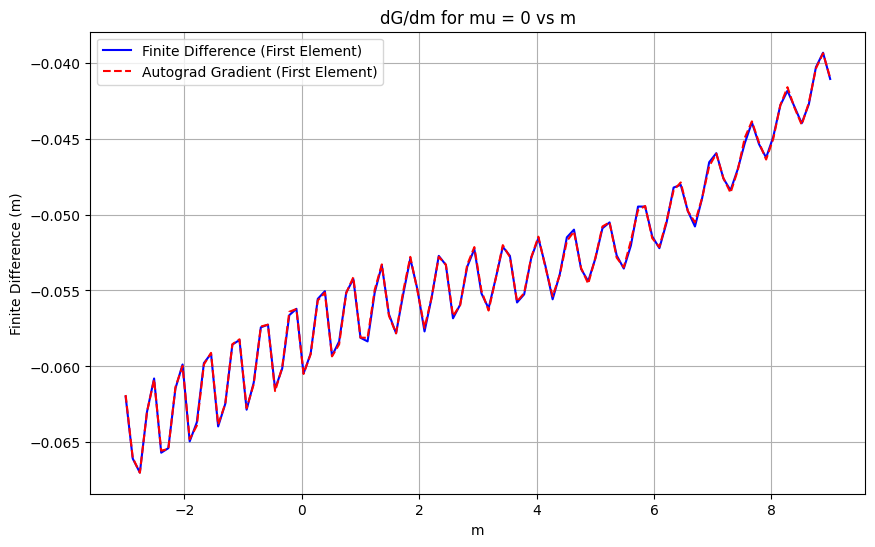

[0.09300142526626587, 0.09211365133523941, 0.09131165593862534, 0.09060943871736526, 0.09000518172979355, 0.08950497955083847, 0.08908922970294952, 0.08876311779022217, 0.08850168436765671, 0.08831439912319183, 0.08816864341497421, 0.08807689696550369, 0.08803058415651321, 0.0880114957690239, 0.08801280707120895, 0.08804010599851608, 0.0880773738026619, 0.08813169598579407, 0.08818871527910233, 0.08824612945318222, 0.08829658478498459, 0.08833947777748108, 0.08837369084358215, 0.08839497715234756, 0.08839844912290573, 0.08837581425905228, 0.08833498507738113, 0.0882721021771431, 0.08817753940820694, 0.08805783838033676, 0.08790254592895508, 0.08771569281816483, 0.08749666810035706, 0.08724009990692139, 0.0869554653763771, 0.0866372287273407, 0.08628806471824646, 0.08590343594551086, 0.0854983702301979, 0.08506997674703598, 0.08461586385965347, 0.08414825797080994, 0.08366736024618149, 0.08318036049604416, 0.08268385380506516, 0.08218186348676682, 0.08168724924325943, 0.0811885967850685

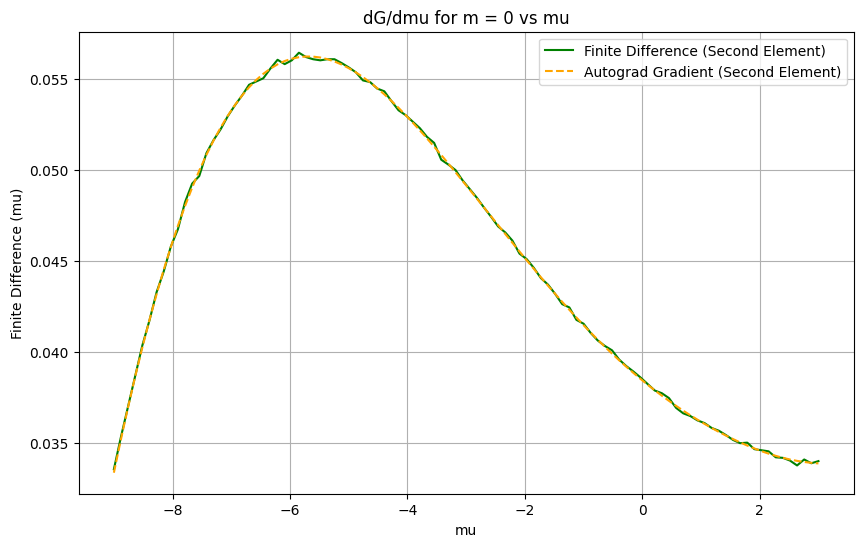

In [315]:
epsilon = 1e-3
finite_diff =[]
autograd_grad = []

start=-3
end=9
mu_test = 0

for i in np.linspace(start, end, 100):
    u_val = torch.tensor([i, mu_test], dtype=torch.float32, requires_grad=True)  # converged u, e.g. tensor([1.7616, -1.2246])
    fd_grad = torch.zeros_like(u_val)

    # Build a helper to compute G given a u vector:
    def compute_G(u_vector):
        values = []
        for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
            if param in params['norm_info']:
                # Using the same transformation as in your code
                values.append(u_vector[j])
            else:
                values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))
        input_params = tuple(v.expand(len(t_FORM), 1) for v in values)
        return limit_state_function_G(t_FORM, input_params)

    LSF = compute_G(u_val)
    LSF.backward()
    grad_u = u_val.grad.detach().clone()

    for k in range(len(u_val)):
        u_plus = u_val.clone()
        u_minus = u_val.clone()
        u_plus[k] += epsilon
        u_minus[k] -= epsilon
        g_plus = compute_G(u_plus).item()
        g_minus = compute_G(u_minus).item()
        fd_grad[k] = (g_plus - g_minus) / (2 * epsilon)

    finite_diff.append(fd_grad.numpy())
    autograd_grad.append(grad_u.numpy())

# Extract the first element of each list in finite_diff
finite_diff_first_elements = [fd[0] for fd in finite_diff]
# Extract the first element of each list in autograd_grad
autograd_grad_first_elements = [ag[0] for ag in autograd_grad]

# Plot the first element of finite_diff against the linspace
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(start, end, 100), finite_diff_first_elements, label='Finite Difference (First Element)', color='blue')
plt.plot(np.linspace(start, end, 100), autograd_grad_first_elements, label='Autograd Gradient (First Element)', color='red', linestyle='--')
plt.xlabel('m')
plt.ylabel('Finite Difference (m)')
plt.title(f'dG/dm for mu = {mu_test} vs m')
plt.legend()
plt.grid()
plt.show()

finite_diff =[]
autograd_grad = []
norm_grad_list = []

start=-9
end=3
m_test = 0
for i in np.linspace(start, end, 100):
    u_val = torch.tensor([m_test, i], dtype=torch.float32, requires_grad=True)  # converged u, e.g. tensor([1.7616, -1.2246])
    fd_grad = torch.zeros_like(u_val)

    # Build a helper to compute G given a u vector:
    def compute_G(u_vector):
        values = []
        for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
            if param in params['norm_info']:
                # Using the same transformation as in your code
                values.append(u_vector[j])
            else:
                values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))
        input_params = tuple(v.expand(len(t_FORM), 1) for v in values)
        return limit_state_function_G(t_FORM, input_params)

    LSF = compute_G(u_val)
    LSF.backward()
    grad_u = u_val.grad.detach().clone()
    norm_grad = torch.norm(grad_u)
    norm_grad_list.append(norm_grad.item())
    for k in range(len(u_val)):
        u_plus = u_val.clone()
        u_minus = u_val.clone()
        u_plus[k] += epsilon
        u_minus[k] -= epsilon
        g_plus = compute_G(u_plus).item()
        g_minus = compute_G(u_minus).item()
        fd_grad[k] = (g_plus - g_minus) / (2 * epsilon)

    finite_diff.append(fd_grad.numpy())
    autograd_grad.append(grad_u.numpy())

finite_diff_second_elements = [fd[1] for fd in finite_diff]
autograd_grad_second_elements = [ag[1] for ag in autograd_grad]
print(norm_grad_list)
# Plot the second element of finite_diff against the linspace
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(start, end, 100), finite_diff_second_elements, label='Finite Difference (Second Element)', color='green')
plt.plot(np.linspace(start, end, 100), autograd_grad_second_elements, label='Autograd Gradient (Second Element)', color='orange', linestyle='--')
plt.xlabel('mu')
plt.ylabel('Finite Difference (mu)')
plt.title(f'dG/dmu for m = {m_test} vs mu')
plt.legend()
plt.grid()
plt.show()


In [316]:
# 1. Wrap u again to ensure it's a fresh, tracked variable
u_final = u.detach().clone().requires_grad_(True)

# 2. Rebuild `values` list using u_final
values = []
for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
    if param in params['norm_info']:
        values.append(u_final[j])  # Adjusted for the damping factor
    else:
        values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))

# 3. Expand to match t
input_params = tuple(v.expand(len(t_FORM), 1) for v in values)

# 4. Re-evaluate G
G_final = limit_state_function_G(t_FORM, input_params)
print("Final G at converged u:", G_final)


Final G at converged u: tensor([6.9141e-06], grad_fn=<AddBackward0>)


In [317]:
limit_state_function_G(t_FORM, input_params)

tensor([6.9141e-06], grad_fn=<AddBackward0>)

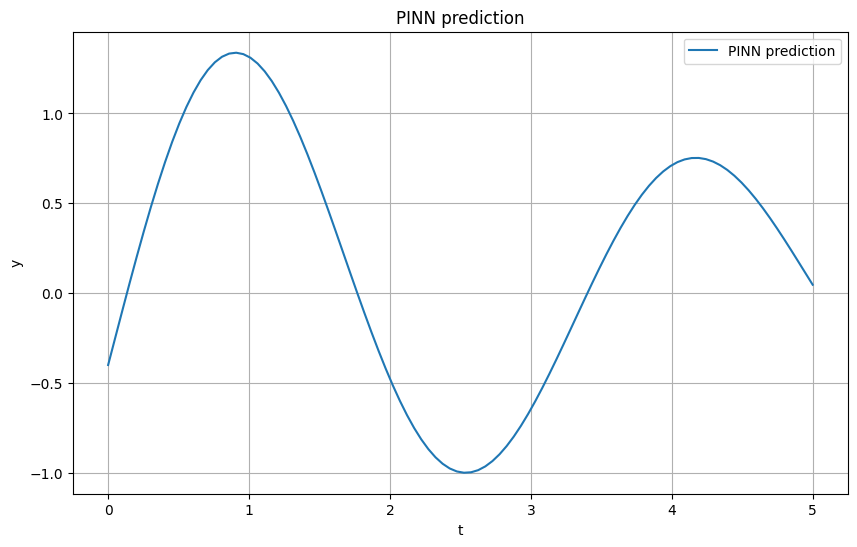

In [318]:
t_test = np.linspace(0, 5, 100)

y_pred = mass_mu_model(torch.from_numpy(t_test).float().view(-1, 1), *input_params)

plt.figure(figsize=(10, 6))
plt.plot(t_test, y_pred.detach().numpy(), label='PINN prediction')
# plt.plot(t_test.detach().numpy(), y_sol,label='Exact solution', linestyle='--')
plt.legend()
plt.title('PINN prediction')
plt.xlabel('t')
plt.ylabel('y')
plt.grid()
plt.show()

In [347]:
m_mpp, mu_mpp = 1.3150, 0.4625
u1_mpp = (m_mpp - m_mean) / m_std
u2_mpp = (mu_mpp - mu_mean) / mu_std

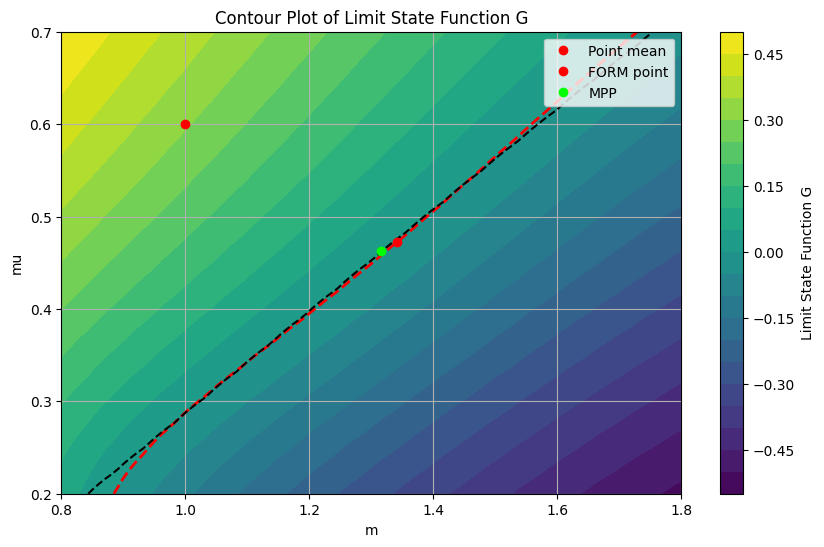

In [348]:
# Convert u → physical space x
physical_values = []
for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
    if param in params['norm_info']:
        physical_values.append(z_score_denormalize(u[j], params['norm_info'][param]))
    else:
        physical_values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))

# Define the grid for m and mu
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 100)
mu_values = np.linspace(mu_mean - 8 * mu_std, mu_mean + 2 * mu_std, 100)
m_grid, mu_grid = np.meshgrid(m_values, mu_values)

# Evaluate the limit state function on the grid
g_values = np.zeros_like(m_grid)
g_values_exact = np.full(m_grid.shape, np.nan)


for i in range(m_grid.shape[0]):
    for j in range(m_grid.shape[1]):
        test_values = [m_grid[i, j], mu_grid[i, j], k_mean, y0_mean, v0_mean]
        test_params = make_input_params(t_FORM, test_values, params['norm_info'])
        g_values[i, j] = limit_state_function_G(t_FORM, test_params).item()
        g_values_exact[i, j] = damped_harmonic_oscillator(t_FORM, *test_values).min() + 1.0  # Exact solution for g(x) = 0
        # Add a contour line at g = 0

# Create the contour plot
plt.figure(figsize=(10, 6))
contour = plt.contourf(m_grid, mu_grid, g_values, levels=20, cmap='viridis')
plt.contour(m_grid, mu_grid, g_values, levels=[0], colors='red', linestyles='--', linewidths=2)
plt.contour(m_grid, mu_grid, g_values_exact, levels=[0], colors='k', linewidths=1.5, linestyles='dashed')
plt.plot(params['norm_info']['m']['mean'], params['norm_info']['mu']['mean'], 'ro', label='Point mean')
plt.plot(physical_values[0].item(), physical_values[1].item(), 'ro', label='FORM point')
plt.plot(m_mpp, mu_mpp, 'o', color='lime', label='MPP')  
plt.legend()
plt.colorbar(contour, label='Limit State Function G')
plt.title('Contour Plot of Limit State Function G')
plt.xlabel('m')
plt.ylabel('mu')
plt.grid(True)
plt.show()

In [349]:
# Define the grid for m and mu
m_values = np.linspace(- 2, 8 ,100)
mu_values = np.linspace(- 8 ,  2 , 100)
m_grid, mu_grid = np.meshgrid(m_values, mu_values)

# Evaluate the limit state function on the grid
g_values = np.zeros_like(m_grid)

for i in range(m_grid.shape[0]):
    for j in range(m_grid.shape[1]):
        grid_values = []
        for k, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
            u_grid=torch.tensor([m_grid[i, j], mu_grid[i, j]], dtype=torch.float32, requires_grad=True)  # converged u, e.g. tensor([1.7616, -1.2246])
            if param in params['norm_info']:
                grid_values.append(u_grid[k])
            else:
                grid_values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))
        # 3. Expand to match t
        input_params = tuple(v.expand(len(t_FORM), 1) for v in grid_values)
        g_values[i, j] = limit_state_function_G(t_FORM, input_params).item()
        # g_values_exact[i, j] = damped_harmonic_oscillator(t_FORM, *grid_values).min() + 1.0
        # Add a contour line at g = 0

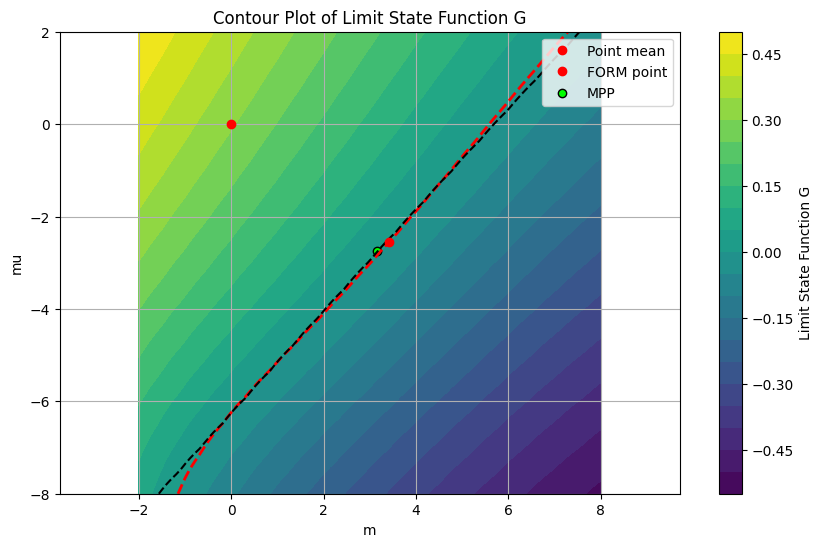

In [350]:
# Create the contour plot
plt.figure(figsize=(10, 6))
contour = plt.contourf(m_grid, mu_grid, g_values, levels=20, cmap='viridis')
plt.contour(m_grid, mu_grid, g_values, levels=[0], colors='red', linestyles='--', linewidths=2)
plt.contour(m_grid, mu_grid, g_values_exact, levels=[0], colors='k', linewidths=1.5, linestyles='dashed')
# plt.plot(1.2716, 0.4345, 'ro', label='Point (m=1.2578, mu=0.4279)')
plt.plot(0, 0, 'ro', label='Point mean')
plt.plot(u[0].detach().numpy(),u[1].detach().numpy() , 'ro', label='FORM point')
plt.scatter(u1_mpp,u2_mpp, color='lime', edgecolor='black',  label='MPP')
plt.legend()
plt.colorbar(contour, label='Limit State Function G')
plt.title('Contour Plot of Limit State Function G')
plt.xlabel('m')
plt.ylabel('mu')
plt.grid(True)
plt.axis('equal')
plt.show()

## Try again, something isnt right